<a href="https://colab.research.google.com/github/SambadRupakheti/LSTM-Modeling/blob/main/Us_chronic_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/ne_110m_admin_1_states_provinces.zip

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from scipy.stats import zscore

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input



In [ ]:
df=pd.read_csv('/content/U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')

<ipython-input-143-e83598b7b7bc>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv')


In [ ]:
df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2010,2010,OR,Oregon,NVSS,Cardiovascular Disease,Mortality from heart failure,NaN,NaN,Number,...,41,CVD,CVD1_4,NMBR,RACE,AIAN,NaN,NaN,NaN,NaN
1,2019,2019,AZ,Arizona,YRBSS,Alcohol,Alcohol use among youth,NaN,%,Crude Prevalence,...,4,ALC,ALC1_1,CRDPREV,GENDER,GENF,NaN,NaN,NaN,NaN
2,2019,2019,OH,Ohio,YRBSS,Alcohol,Alcohol use among youth,NaN,%,Crude Prevalence,...,39,ALC,ALC1_1,CRDPREV,GENDER,GENM,NaN,NaN,NaN,NaN
3,2019,2019,US,United States,YRBSS,Alcohol,Alcohol use among youth,NaN,%,Crude Prevalence,...,59,ALC,ALC1_1,CRDPREV,RACE,ASN,NaN,NaN,NaN,NaN
4,2015,2015,VI,Virgin Islands,YRBSS,Alcohol,Alcohol use among youth,NaN,%,Crude Prevalence,...,78,ALC,ALC1_1,CRDPREV,GENDER,GENM,NaN,NaN,NaN,NaN


In [ ]:
file_path = "/content/raw_data (1).csv"
df_population = pd.read_csv(file_path)
df_population=df_population.drop(0)

In [ ]:
df_population.head(50)

,Location,Children 0-18,Adults 19-25,Adults 26-34,Adults 35-54,Adults 55-64,65+,Total
1,Alabama,1164400,428000,556800,1246500,641000,908500,4945200
2,Alaska,181400,49900,96700,185800,86400,100300,700500
3,Arizona,1644800,646500,905400,1768000,870800,1417500,7252900
4,Arkansas,723600,259400,344900,742100,372400,531300,2973600
5,California,8768200,3322200,5017900,10181000,4638300,6210500,38138100
6,Colorado,1256100,490700,818000,1564600,669200,926100,5724600
7,Connecticut,751800,275800,410300,902000,503300,671500,3514700
8,Delaware,219400,77600,107300,241300,140200,217100,1002900
9,District of Columbia,127300,56200,129700,183500,62100,87300,646000
10,Florida,4535300,1671400,2483300,5573400,3000200,4812300,22076000


<H3>Exploring the data</H3>

In [ ]:
df.columns
total_rows = len(df)

In [ ]:
for i in df.columns:

  a = df[i].unique()
  if a.size <=1:
    df.drop(columns=i,axis=1,inplace=True)

In [ ]:
null_counts = df.isnull().sum()

In [ ]:
for column, count in null_counts.items():
    print(f"{column}: {count} null values with total of {total_rows} and percentage of {count / total_rows * 100:.2f}%")


YearStart: 0 null values with total of 1185676 and percentage of 0.00%
YearEnd: 0 null values with total of 1185676 and percentage of 0.00%
LocationAbbr: 0 null values with total of 1185676 and percentage of 0.00%
LocationDesc: 0 null values with total of 1185676 and percentage of 0.00%
DataSource: 0 null values with total of 1185676 and percentage of 0.00%
Topic: 0 null values with total of 1185676 and percentage of 0.00%
Question: 0 null values with total of 1185676 and percentage of 0.00%
DataValueUnit: 152123 null values with total of 1185676 and percentage of 12.83%
DataValueType: 0 null values with total of 1185676 and percentage of 0.00%
DataValue: 378734 null values with total of 1185676 and percentage of 31.94%
DataValueAlt: 381098 null values with total of 1185676 and percentage of 32.14%
DataValueFootnoteSymbol: 791966 null values with total of 1185676 and percentage of 66.79%
DatavalueFootnote: 791966 null values with total of 1185676 and percentage of 66.79%
LowConfidenceL

In [ ]:
df["DatavalueFootnote"].unique()

array([nan, 'No data available',
       'Data not shown because of too few respondents or cases',
       'Less than 60 respondents, interpret with caution',
       'US estimate/number is based on fewer than 50 states and the District of Columbia',
       'DC was not rated for this measure because the measure addresses state versus local authority and does not apply to the District of Columbia',
       'Estimate is based on the first 3 quarters of 2015 and is not directly comparable to estimates in prior years due to changes in ICD codes',
       'State directly controlled the sale of (beer/wine/distilled spirits) at the retail and/or wholesale levels. State prices for (beer/wine/distilled spirits) combined both markups and taxes, so tax rates for this beverage type could not be determined.',
       'Sample size of denominator and/or age group for age-standardization is less than 50 or relative standard error is more than 30%',
       'The state registry opted not to present state-speci

In [ ]:
df.drop(columns=["DatavalueFootnote"],axis=1,inplace=True)
df.drop(columns=["DataValueFootnoteSymbol"],axis=1,inplace=True)
df.drop(columns=["HighConfidenceLimit"],axis=1,inplace=True)
df.drop(columns=["LowConfidenceLimit"],axis=1,inplace=True)

In [ ]:
null_counts = df.isnull().sum()
for column, count in null_counts.items():
    print(f"{column}: {count} null values with total of {total_rows} and percentage of {count / total_rows * 100:.2f}%")


YearStart: 0 null values with total of 1185676 and percentage of 0.00%
YearEnd: 0 null values with total of 1185676 and percentage of 0.00%
LocationAbbr: 0 null values with total of 1185676 and percentage of 0.00%
LocationDesc: 0 null values with total of 1185676 and percentage of 0.00%
DataSource: 0 null values with total of 1185676 and percentage of 0.00%
Topic: 0 null values with total of 1185676 and percentage of 0.00%
Question: 0 null values with total of 1185676 and percentage of 0.00%
DataValueUnit: 152123 null values with total of 1185676 and percentage of 12.83%
DataValueType: 0 null values with total of 1185676 and percentage of 0.00%
DataValue: 378734 null values with total of 1185676 and percentage of 31.94%
DataValueAlt: 381098 null values with total of 1185676 and percentage of 32.14%
StratificationCategory1: 0 null values with total of 1185676 and percentage of 0.00%
Stratification1: 0 null values with total of 1185676 and percentage of 0.00%
GeoLocation: 10166 null valu

In [ ]:
grouped_questions = df.groupby('QuestionID').agg({'Topic': 'first', 'Question': set}).reset_index()



In [ ]:
df = df[~df['Topic'].str.lower().str.contains('reproductive health')]

df = df[~df['Topic'].str.lower().str.contains('oral health')]

df = df[~df['Topic'].str.lower().str.contains('immunization')]


<H3>Dataset cleaning</H3>


In [ ]:
unique_data_types = df['DataValueType'].unique()

for data_type in unique_data_types:
    # Filter rows for this DataValueType
    subset = df.loc[df['DataValueType'] == data_type, 'DataValueUnit']
    # Get unique (DataValueUnit, DataSource) pairs
    unique_pairs = subset.dropna().drop_duplicates()
    print(f"DataValueType = {data_type}\nUnique DataValueUnit - DataSource Pairs:")
    print(unique_pairs, "\n")


DataValueType = Number
Unique DataValueUnit - DataSource Pairs:
173                      Number
1188        cases per 1,000,000
2792                      Years
368486        cases per 100,000
462734    per 100,000 residents
478947    pack sales per capita
Name: DataValueUnit, dtype: object 

DataValueType = Crude Prevalence
Unique DataValueUnit - DataSource Pairs:
1    %
Name: DataValueUnit, dtype: object 

DataValueType = Age-adjusted Rate
Unique DataValueUnit - DataSource Pairs:
24        cases per 100,000
116        cases per 10,000
216     cases per 1,000,000
1556        cases per 1,000
Name: DataValueUnit, dtype: object 

DataValueType = Crude Rate
Unique DataValueUnit - DataSource Pairs:
25        cases per 100,000
118        cases per 10,000
174     cases per 1,000,000
1587        cases per 1,000
Name: DataValueUnit, dtype: object 

DataValueType = Average Annual Number
Unique DataValueUnit - DataSource Pairs:
Series([], Name: DataValueUnit, dtype: object) 

DataValueType = Aver

In [ ]:
matching_values = [
    "Age-adjusted Rate",
    "Average Annual Age-adjusted Rate",
    "Adjusted by age, sex, race and ethnicity",
    "Age-adjusted Prevalence",
    "Age-adjusted Mean",
    "Local control of the regulation of alcohol outlet density",
    "US Dollars",
    "Commercial host (dram shop) liability status for alcohol service",
    "Per capita alcohol consumption",
    "Yes/No"
]

count_matches = df["DataValueType"].isin(matching_values).sum()

total_rows = len(df)

percentage = (count_matches / total_rows) * 100

print(f"Number of matching rows: {count_matches}")
print(f"Total rows: {total_rows}")
print(f"Percentage of matching rows: {percentage:.2f}%")

Number of matching rows: 452790
Total rows: 1144747
Percentage of matching rows: 39.55%


In [ ]:
not_in_list_mask = ~df["DataValueType"].isin(matching_values)
remaining_subset = df[not_in_list_mask]

# Optionally, you might want percentages:
missing_perc = (remaining_subset.isna().sum() / len(remaining_subset)) * 100
print("\nNaN percentages per column (in the remaining subset):")
print(missing_perc)


NaN percentages per column (in the remaining subset):
YearStart                     0.000000
YearEnd                       0.000000
LocationAbbr                  0.000000
LocationDesc                  0.000000
DataSource                    0.000000
Topic                         0.000000
Question                      0.000000
DataValueUnit                21.633136
DataValueType                 0.000000
DataValue                    32.293481
DataValueAlt                 32.293481
StratificationCategory1       0.000000
Stratification1               0.000000
GeoLocation                   0.886471
LocationID                    0.000000
TopicID                       0.000000
QuestionID                    0.000000
DataValueTypeID               0.000000
StratificationCategoryID1     0.000000
StratificationID1             0.000000
dtype: float64


In [ ]:
df=df.drop(df[(df["Question"]=="Postpartum checkup")].index)
df=df.drop(df[(df["Question"]=="Current health care coverage among women aged 18-44 years")].index)
df=df.drop(df[(df["Question"]=="Population served by community water systems that receive fluoridated drinking water")].index)
df=df.drop(df[(df["Question"]=="Self-rated health status among women aged 18-44 years")].index)
df=df.drop(df[(df["Question"]=="Proportion of the population protected by a comprehensive smoke-free policy prohibiting smoking in all indoor areas of workplaces and public places, including restaurants and bars")].index)
df=df.drop(df[(df["Question"]=="High school completion among women aged 18-44 years")].index)
df=df.drop(df[(df["Question"]=="High school completion among adults aged 18-24 years")].index)
df=df.drop(df[(df["Question"]=="Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with asthma")].index)
df=df.drop(df[(df["Question"]=="High school completion among adults aged 45-64 years")].index)
df=df.drop(df[(df["Question"]=="Cholesterol screening among adults aged >= 18 years")].index)

In [ ]:
matching_values = [
    "Age-adjusted Rate",
    "Average Annual Age-adjusted Rate",
    "Age-adjusted Prevalence",
    "Age-adjusted Mean",
    "Local control of the regulation of alcohol outlet density",
    "Adjusted by age, sex, race and ethnicity",
    "US Dollars",
    "Commercial host (dram shop) liability status for alcohol service",
    "Per capita alcohol consumption",
    "Yes/No",
    "Adjusted by age, sex, race, and ethnicity",
    "Years","pack sales per capita"
]

df = df.loc[~df["DataValueType"].isin(matching_values)]


In [ ]:

df_population.columns = ['State', 'Age_0_17', 'Age_18_24', 'Age_25_44', 'Age_45_64', 'Age_65_74', 'Age_75+', 'Total_Population']

df_population = df_population.dropna(subset=['State'])

for col in df_population.columns[1:]:
    df_population[col] = pd.to_numeric(df_population[col], errors='coerce')

df_population.head()

,State,Age_0_17,Age_18_24,Age_25_44,Age_45_64,Age_65_74,Age_75+,Total_Population
1,Alabama,1164400,428000,556800,1246500,641000,908500,4945200
2,Alaska,181400,49900,96700,185800,86400,100300,700500
3,Arizona,1644800,646500,905400,1768000,870800,1417500,7252900
4,Arkansas,723600,259400,344900,742100,372400,531300,2973600
5,California,8768200,3322200,5017900,10181000,4638300,6210500,38138100




<H3>Data Normalization </H3>
<p> Data is being normalized to percentage so that it witll be easier to compare and see trends


In [ ]:
df = pd.merge(
    df,
    df_population[['State', 'Total_Population']],  # only the columns we need from df_population
    left_on='LocationDesc',   # column in df
    right_on='State',         # column in df_population
    how='left'
)

In [ ]:
states_in=df_population["State"].unique()

In [ ]:
len(states_in)-1

51

In [ ]:
df.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType', 'DataValue',
       'DataValueAlt', 'StratificationCategory1', 'Stratification1',
       'GeoLocation', 'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID',
       'StratificationCategoryID1', 'StratificationID1', 'State',
       'Total_Population'],
      dtype='object')

In [ ]:
df = df[df['Total_Population'].notna()]

In [ ]:
### this is where main normalization is happening
data = df
def standardize_percentage(value,pop):
    if pd.notna(value):
      value=float(value)
      return value
    return value

def standardize_rate(value, unit):
    if pd.notna(value):
        if unit == "cases per 100,000":
          try:
            return (float(value) / 1000)
          except:
            return 0
        elif unit == "cases per 10,000":
          try:
            return (float(value) / 100)
          except:
            return 0
        elif unit == "cases per 1,000":
          try:
            return (float(value) / 10)
          except:
            return 0
        elif unit == "cases per 1,000,000":
          try:
            return (float(value) / 10000)
          except:
            return 0
        elif unit == "per 100,000 residents":
          try:
            return (float(value) / 1000)
          except:
            return 0
        elif unit == "per 100,000":
          try:
            return (float(value) / 1000)
          except:
            return 0
    else:
      return 0

def standardize_units(row):
    unit = row["DataValueUnit"]
    value = row["DataValue"]
    pop = row["Total_Population"]
    value_type = row["DataValueType"]
    if pd.isna(value):
        return value
    value=math.floor(float(value))
    if pd.isna(unit):
      return_val=value/pop*100
      return return_val
    if value_type == "mean":
      if pop and pop != 0:
        return_val=value/pop*100
        if return_val > 100:
          print(return_val)
        return return_val
    elif value_type == "median":
      if pop and pop != 0:
        return_val=value/pop*100
        if return_val > 100:
          print(return_val)
        return return_val
    elif value_type == "Number":
      if pop and pop != 0:
        if pd.isnull(unit)==False:
          return_val=value/pop*100
          if return_val > 100:
            print(return_val)
          return return_val
    if unit == "%":
      if pop and pop != 0:
        return standardize_percentage(value,pop)
    elif unit in ["cases per 100,000", "cases per 10,000","per 100,000","per 100,000 residents","cases per 1,000,000","cases per 1,000"]:
        return_val=standardize_rate(value, unit)
        try:
          if return_val > 100:
            print(return_val)
        except:
          print(value, unit)
        return return_val
    else:
        return_val=float(value)

        if return_val > 100:
          print("unit",unit)
          print("value_type",value_type)
          print("converted here",return_val)
        return return_val

data["StandardizedDataValue"] = data.apply(standardize_units, axis=1).astype(float)


In [ ]:
data.head(50)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,State,Total_Population,StandardizedDataValue
0,2010,2010,OR,Oregon,NVSS,Cardiovascular Disease,Mortality from heart failure,NaN,Number,30,...,POINT (-120.15503132599969 44.56744942400047),41,CVD,CVD1_4,NMBR,RACE,AIAN,Oregon,4156400.0,0.000722
1,2019,2019,AZ,Arizona,YRBSS,Alcohol,Alcohol use among youth,%,Crude Prevalence,29.5,...,POINT (-111.76381127699972 34.865970280000454),4,ALC,ALC1_1,CRDPREV,GENDER,GENF,Arizona,7252900.0,29.000000
2,2019,2019,OH,Ohio,YRBSS,Alcohol,Alcohol use among youth,%,Crude Prevalence,22.5,...,POINT (-82.40426005599966 40.06021014100048),39,ALC,ALC1_1,CRDPREV,GENDER,GENM,Ohio,11464600.0,22.000000
5,2020,2020,AL,Alabama,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,59.1,...,POINT (-86.63186076199969 32.84057112200048),1,ALC,ALC1_2,CRDPREV,RACE,WHT,Alabama,4945200.0,59.000000
6,2015,2015,DE,Delaware,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,55.6,...,POINT (-75.57774116799965 39.008830667000495),10,ALC,ALC1_2,CRDPREV,OVERALL,OVR,Delaware,1002900.0,55.000000
7,2019,2019,FL,Florida,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,58.1,...,POINT (-81.92896053899966 28.932040377000476),12,ALC,ALC1_2,CRDPREV,OVERALL,OVR,Florida,22076000.0,58.000000
8,2018,2018,KS,Kansas,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,62.6,...,POINT (-98.20078122699965 38.34774030000045),20,ALC,ALC1_2,CRDPREV,OVERALL,OVR,Kansas,2835800.0,62.000000
9,2013,2013,MS,Mississippi,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,NaN,...,POINT (-89.53803082499968 32.745510099000455),28,ALC,ALC1_2,CRDPREV,OVERALL,OVR,Mississippi,2833500.0,NaN
10,2015,2015,NJ,New Jersey,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,40.1,...,POINT (-74.27369128799967 40.13057004800049),34,ALC,ALC1_2,CRDPREV,RACE,HIS,New Jersey,9124100.0,40.000000
11,2020,2020,PA,Pennsylvania,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,59.5,...,POINT (-77.86070029399963 40.79373015200048),42,ALC,ALC1_2,CRDPREV,OVERALL,OVR,Pennsylvania,12527800.0,59.000000


#Data Vizualization

In [ ]:
data_gender = data[data['StratificationCategory1'] == 'Gender']
data_race= data[data['StratificationCategory1'] == 'Race/Ethnicity']
data_overall= data[data['StratificationCategory1'] == 'Overall']


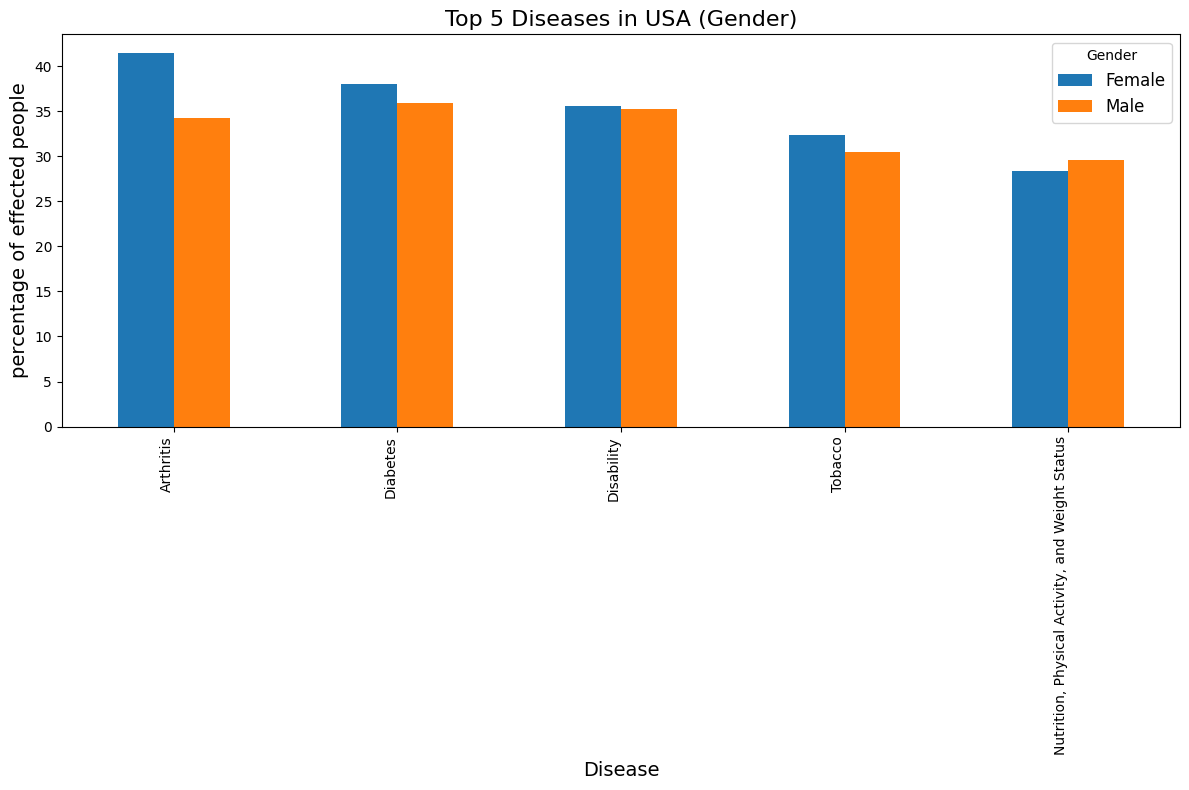

In [ ]:
gender_topic_summary = data_gender.groupby(['Topic', 'Stratification1'])['StandardizedDataValue'].mean().unstack()

top_5_topics_gender = gender_topic_summary.sum(axis=1).nlargest(5).index
gender_topic_summary = gender_topic_summary.loc[top_5_topics_gender]

gender_topic_summary.plot(kind='bar', figsize=(12, 8))
plt.title('Top 5 Diseases in USA (Gender)', fontsize=16)
plt.xlabel('Disease', fontsize=14)
plt.ylabel('percentage of effected people', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.legend(title='Gender', fontsize=12)
plt.tight_layout()

plt.show()


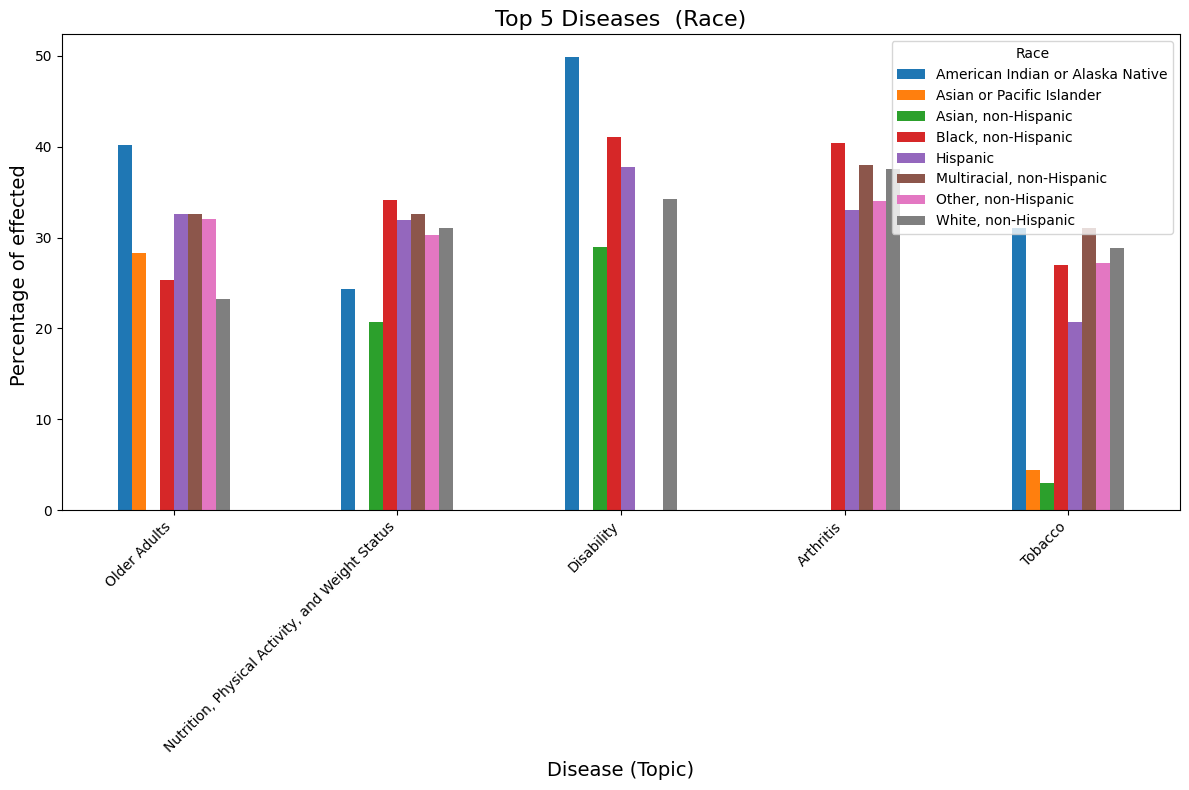

In [ ]:
race_topic_summary = data_race.groupby(['Topic', 'Stratification1'])['StandardizedDataValue'].mean().unstack()

# Get the top 5 diseases based on the total sum
top_5_topics_race = race_topic_summary.sum(axis=1).nlargest(5).index
race_topic_summary = race_topic_summary.loc[top_5_topics_race]

# Plot
race_topic_summary.plot(kind='bar', figsize=(12, 8))
plt.title('Top 5 Diseases  (Race)', fontsize=16)
plt.xlabel('Disease (Topic)', fontsize=14)
plt.ylabel('Percentage of effected ', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Race', fontsize=10,loc="upper right")
plt.tight_layout()

# Display plot
plt.show()


<ipython-input-172-fb67e1bd3ef7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_overall['StandardizedDataValue'] = pd.to_numeric(data_overall['StandardizedDataValue'], errors='coerce')


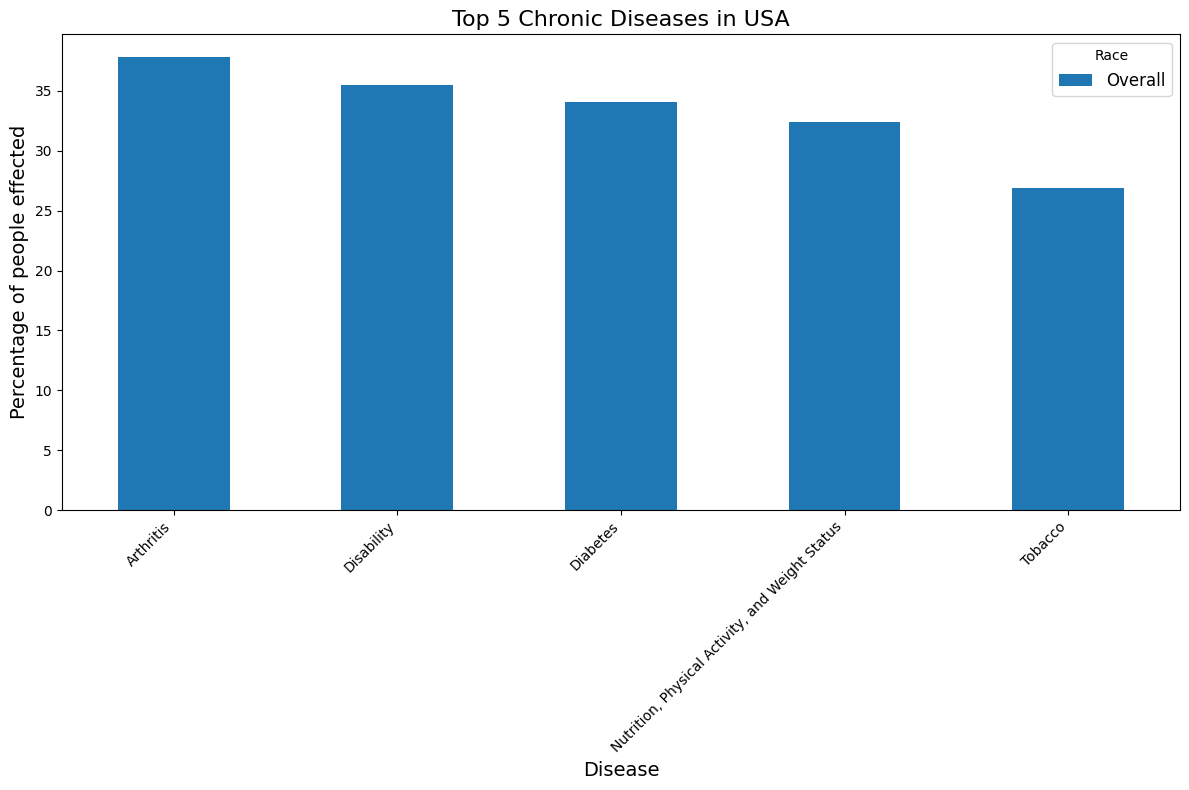

In [ ]:
data_overall = data_overall.dropna(subset=['StandardizedDataValue'])
data_overall['StandardizedDataValue'] = pd.to_numeric(data_overall['StandardizedDataValue'], errors='coerce')

overall_topic_summary = data_overall.groupby(['Topic', 'Stratification1'])['StandardizedDataValue'].mean().unstack()

top_5_diseases = overall_topic_summary.sum(axis=1).nlargest(5).index
filtered_data = overall_topic_summary.loc[top_5_diseases]

filtered_data.plot(kind='bar', figsize=(12, 8))
plt.title('Top 5 Chronic Diseases in USA', fontsize=16)
plt.xlabel('Disease', fontsize=14)
plt.ylabel('Percentage of people effected', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Race', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:

data_map = data.dropna(subset=['StandardizedDataValue'])


In [ ]:
data_map.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,State,Total_Population,StandardizedDataValue
0,2010,2010,OR,Oregon,NVSS,Cardiovascular Disease,Mortality from heart failure,NaN,Number,30,...,POINT (-120.15503132599969 44.56744942400047),41,CVD,CVD1_4,NMBR,RACE,AIAN,Oregon,4156400.0,0.000722
1,2019,2019,AZ,Arizona,YRBSS,Alcohol,Alcohol use among youth,%,Crude Prevalence,29.5,...,POINT (-111.76381127699972 34.865970280000454),4,ALC,ALC1_1,CRDPREV,GENDER,GENF,Arizona,7252900.0,29.000000
2,2019,2019,OH,Ohio,YRBSS,Alcohol,Alcohol use among youth,%,Crude Prevalence,22.5,...,POINT (-82.40426005599966 40.06021014100048),39,ALC,ALC1_1,CRDPREV,GENDER,GENM,Ohio,11464600.0,22.000000
5,2020,2020,AL,Alabama,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,59.1,...,POINT (-86.63186076199969 32.84057112200048),1,ALC,ALC1_2,CRDPREV,RACE,WHT,Alabama,4945200.0,59.000000
6,2015,2015,DE,Delaware,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,55.6,...,POINT (-75.57774116799965 39.008830667000495),10,ALC,ALC1_2,CRDPREV,OVERALL,OVR,Delaware,1002900.0,55.000000


In [ ]:
data_map["Topic"].unique()

array(['Cardiovascular Disease', 'Alcohol', 'Arthritis', 'Asthma',
       'Cancer', 'Chronic Kidney Disease',
       'Chronic Obstructive Pulmonary Disease', 'Mental Health',
       'Tobacco', 'Overarching Conditions', 'Diabetes',
       'Nutrition, Physical Activity, and Weight Status', 'Disability',
       'Older Adults'], dtype=object)

In [ ]:
data_map.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource',
       'Topic', 'Question', 'DataValueUnit', 'DataValueType', 'DataValue',
       'DataValueAlt', 'StratificationCategory1', 'Stratification1',
       'GeoLocation', 'LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID',
       'StratificationCategoryID1', 'StratificationID1', 'State',
       'Total_Population', 'StandardizedDataValue'],
      dtype='object')

In [ ]:
data_map.groupby('State')['StandardizedDataValue'].idxmax()

,StandardizedDataValue
State,
Alabama,365485
Alaska,363845
Arizona,378949
Arkansas,376415
California,384146
Colorado,384953
Connecticut,396377
Delaware,409318
District of Columbia,7579


In [ ]:
data_map.loc[data_map.groupby('State')['StandardizedDataValue'].idxmax()]

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,DataValueUnit,DataValueType,DataValue,...,GeoLocation,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,State,Total_Population,StandardizedDataValue
365485,2014,2014,AL,Alabama,BRFSS,Cancer,Recent Papanicolaou smear use among women aged...,%,Crude Prevalence,93.2,...,POINT (-86.63186076199969 32.84057112200048),1,CAN,CAN2_2,CRDPREV,RACE,BLK,Alabama,4945200.0,93.0
363845,2012,2012,AK,Alaska,BRFSS,Cancer,Papanicolaou smear use among adult women aged ...,%,Crude Prevalence,95.5,...,POINT (-147.72205903599973 64.84507995700051),2,CAN,CAN2_1,CRDPREV,RACE,MRC,Alaska,700500.0,95.0
378949,2020,2020,AZ,Arizona,BRFSS,Cancer,Papanicolaou smear use among adult women aged ...,%,Crude Prevalence,93.6,...,POINT (-111.76381127699972 34.865970280000454),4,CAN,CAN2_1,CRDPREV,RACE,BLK,Arizona,7252900.0,93.0
376415,2017,2017,AR,Arkansas,BRFSS,Diabetes,Prevalence of high blood pressure among adults...,%,Crude Prevalence,94.2,...,POINT (-92.27449074299966 34.74865012400045),5,DIA,DIA11_2,CRDPREV,RACE,BLK,Arkansas,2973600.0,94.0
384146,2014,2014,CA,California,BRFSS,Cancer,Mammography use among women aged 50-74 years,%,Crude Prevalence,91.4,...,POINT (-120.99999953799971 37.63864012300047),6,CAN,CAN1_0,CRDPREV,RACE,BLK,California,38138100.0,91.0
384953,2018,2018,CO,Colorado,BRFSS,Cardiovascular Disease,Pneumococcal vaccination among noninstitutiona...,%,Crude Prevalence,92.1,...,POINT (-106.13361092099967 38.843840757000464),8,CVD,CVD10_2,CRDPREV,GENDER,GENF,Colorado,5724600.0,92.0
396377,2012,2012,CT,Connecticut,BRFSS,Cancer,Recent Papanicolaou smear use among women aged...,%,Crude Prevalence,92.4,...,POINT (-72.64984095199964 41.56266102000046),9,CAN,CAN2_2,CRDPREV,RACE,BLK,Connecticut,3514700.0,92.0
409318,2012,2012,DE,Delaware,BRFSS,Cancer,Recent Papanicolaou smear use among women aged...,%,Crude Prevalence,95.9,...,POINT (-75.57774116799965 39.008830667000495),10,CAN,CAN2_2,CRDPREV,RACE,BLK,Delaware,1002900.0,95.0
7579,2019,2019,DC,District of Columbia,PRAMS,Alcohol,Alcohol use before pregnancy,%,Crude Prevalence,93,...,POINT (-77.036871 38.907192),11,ALC,ALC1_2,CRDPREV,RACE,WHT,District of Columbia,646000.0,93.0
414937,2016,2016,FL,Florida,BRFSS,Cardiovascular Disease,Pneumococcal vaccination among noninstitutiona...,%,Crude Prevalence,94.3,...,POINT (-81.92896053899966 28.932040377000476),12,CVD,CVD10_2,CRDPREV,RACE,OTH,Florida,22076000.0,94.0


In [ ]:
unique_topics = data_map['Topic'].unique()
num_topics = len(unique_topics)

cmap = plt.cm.get_cmap('tab20', num_topics)

topic_colors = {}
for i, topic in enumerate(unique_topics):
    color_rgba = cmap(i)
    topic_colors[topic] = mcolors.to_hex(color_rgba)


<ipython-input-180-fe2fe4419919>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_topics)


In [ ]:
topic_colors

{'Cardiovascular Disease': '#1f77b4',
 'Alcohol': '#aec7e8',
 'Arthritis': '#ffbb78',
 'Asthma': '#2ca02c',
 'Cancer': '#d62728',
 'Chronic Kidney Disease': '#ff9896',
 'Chronic Obstructive Pulmonary Disease': '#c5b0d5',
 'Mental Health': '#8c564b',
 'Tobacco': '#e377c2',
 'Overarching Conditions': '#f7b6d2',
 'Diabetes': '#c7c7c7',
 'Nutrition, Physical Activity, and Weight Status': '#bcbd22',
 'Disability': '#17becf',
 'Older Adults': '#9edae5'}

In [ ]:
df_agg = data.groupby(['State', 'Topic',"Question"], as_index=False)['StandardizedDataValue'].mean()


In [ ]:
dominant_disease = df_agg.loc[df_agg.groupby('State')['StandardizedDataValue'].idxmax()].copy()
dominant_disease['Color'] = dominant_disease['Topic'].map(topic_colors)

In [ ]:
dominant_disease

,State,Topic,Question,StandardizedDataValue,Color
47,Alabama,Cancer,Recent Papanicolaou smear use among women aged...,83.500000,#d62728
286,Alaska,"Nutrition, Physical Activity, and Weight Status",Mean maternity practices in infant nutrition c...,81.250000,#bcbd22
400,Arizona,Cardiovascular Disease,Pneumococcal vaccination among noninstitutiona...,81.066667,#1f77b4
554,Arkansas,Cancer,Recent Papanicolaou smear use among women aged...,82.000000,#d62728
793,California,"Nutrition, Physical Activity, and Weight Status",Mean maternity practices in infant nutrition c...,83.250000,#bcbd22
907,Colorado,Cardiovascular Disease,Pneumococcal vaccination among noninstitutiona...,85.227273,#1f77b4
1060,Connecticut,Cancer,Papanicolaou smear use among adult women aged ...,83.700000,#d62728
1300,Delaware,"Nutrition, Physical Activity, and Weight Status",Mean maternity practices in infant nutrition c...,84.000000,#bcbd22
1399,District of Columbia,Cancer,Recent Papanicolaou smear use among women aged...,83.625000,#d62728
1630,Florida,"Nutrition, Physical Activity, and Weight Status",Census tracts with healthier food retailers wi...,78.500000,#bcbd22


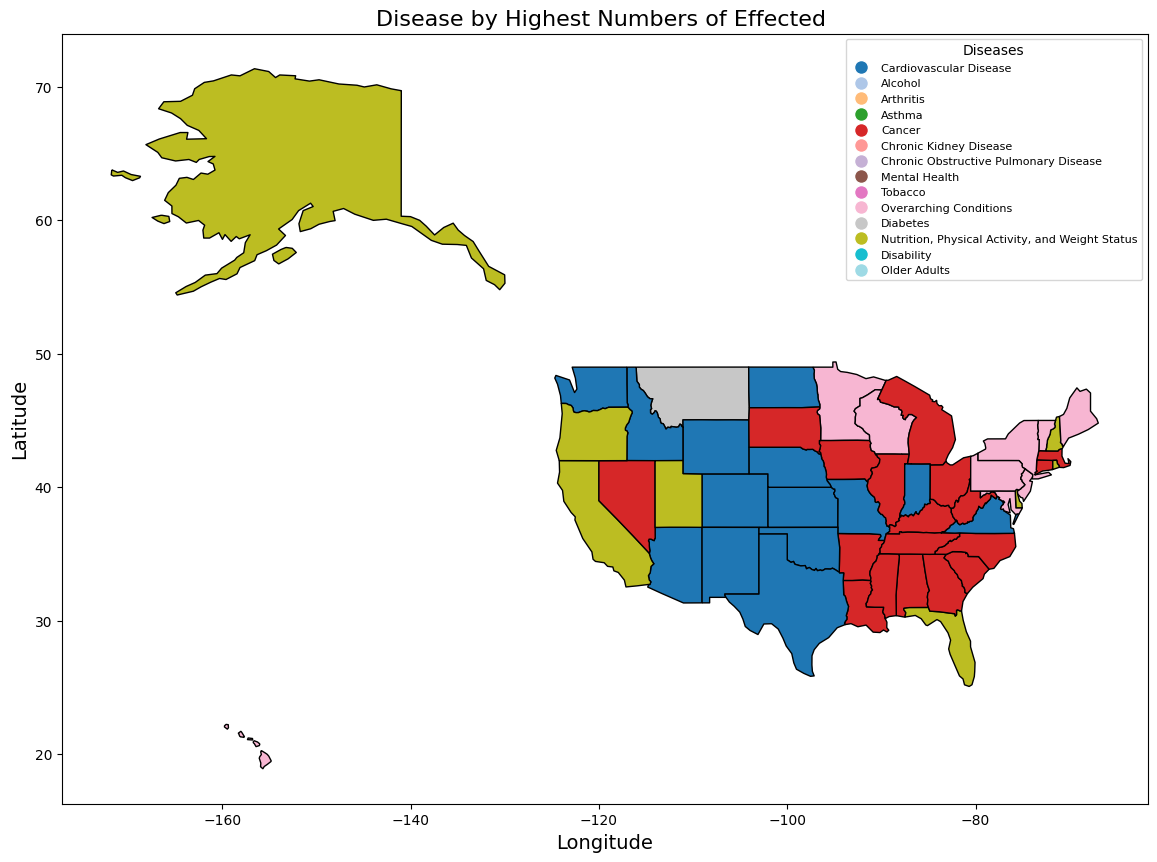

In [ ]:

world_path = "/content/ne_110m_admin_1_states_provinces.shp"
world = gpd.read_file(world_path)

world = world.merge(dominant_disease, left_on='name', right_on='State', how='left')

fig, ax = plt.subplots(figsize=(15, 10))

world.plot(
    ax=ax,
    color=world['Color'].fillna('blue'),
    edgecolor='black'
)

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
               markersize=10, label=topic)
    for topic, color in topic_colors.items()
]

plt.legend(handles=handles, title="Diseases", fontsize=8)
plt.title("Disease by Highest Numbers of Effected ", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.show()


Empty DataFrame
Columns: [YearStart, YearEnd, LocationAbbr, LocationDesc, DataSource, Topic, Question, DataValueUnit, DataValueType, DataValue, DataValueAlt, StratificationCategory1, Stratification1, GeoLocation, LocationID, TopicID, QuestionID, DataValueTypeID, StratificationCategoryID1, StratificationID1, State, Total_Population, StandardizedDataValue, Zscore]
Index: []

[0 rows x 24 columns]


<ipython-input-215-dc7169de78bb>:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


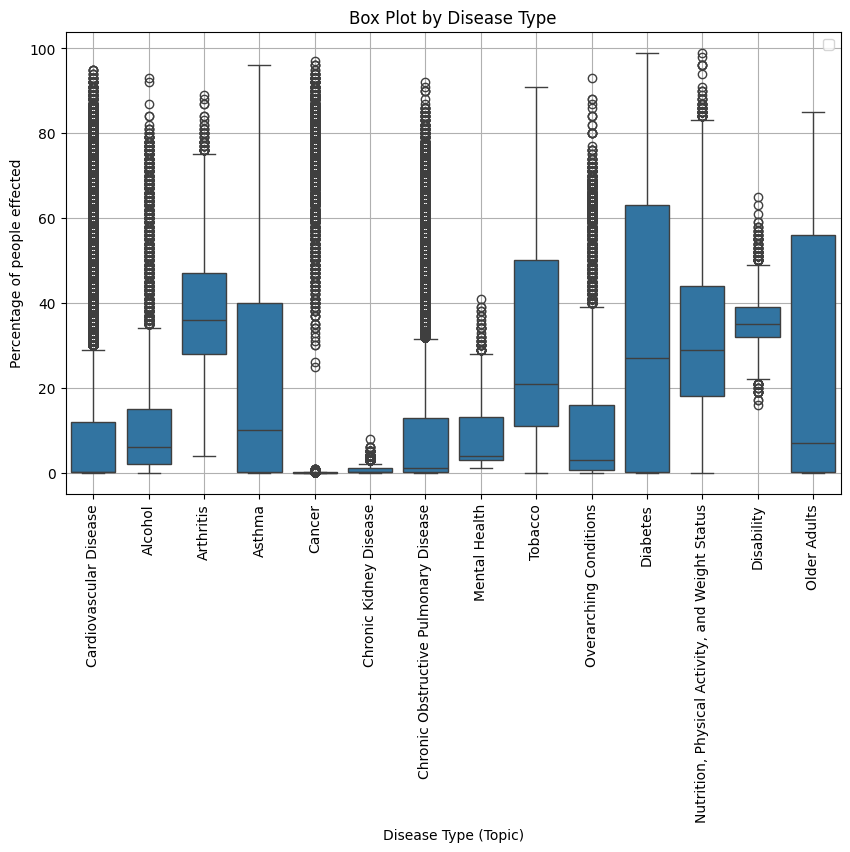

In [ ]:
data['Zscore'] = zscore(data['StandardizedDataValue'])

outliers = data[abs(data['Zscore']) > 3]

print(outliers)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Topic', y='StandardizedDataValue', data=data)


plt.xlabel("Disease Type (Topic)")
plt.ylabel("Percentage of people effected")
plt.title("Box Plot by Disease Type")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()


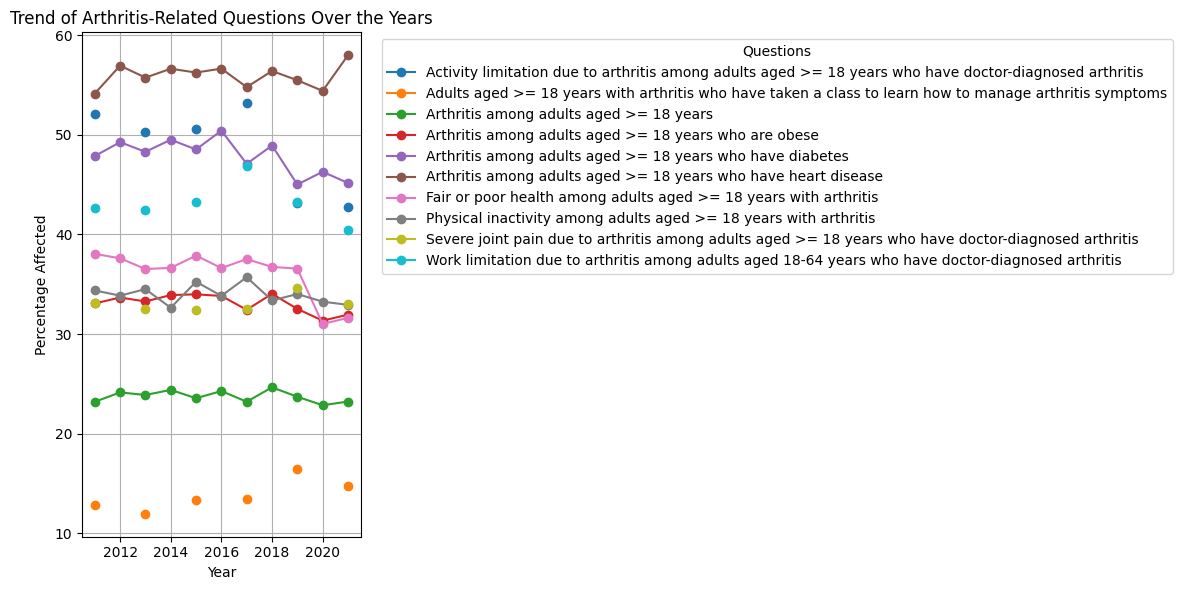

In [ ]:
df_arthritis = data[data['Topic']=="Arthritis"].copy()

df_trend = df_arthritis.groupby(['YearStart', 'Question'])['StandardizedDataValue'].mean().unstack()

plt.figure(figsize=(12, 6))
for question in df_trend.columns:
    plt.plot(df_trend.index, df_trend[question], marker='o', label=question)

plt.title('Trend of Arthritis-Related Questions Over the Years')
plt.xlabel('Year')
plt.ylabel('Percentage Affected')
plt.legend(title="Questions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


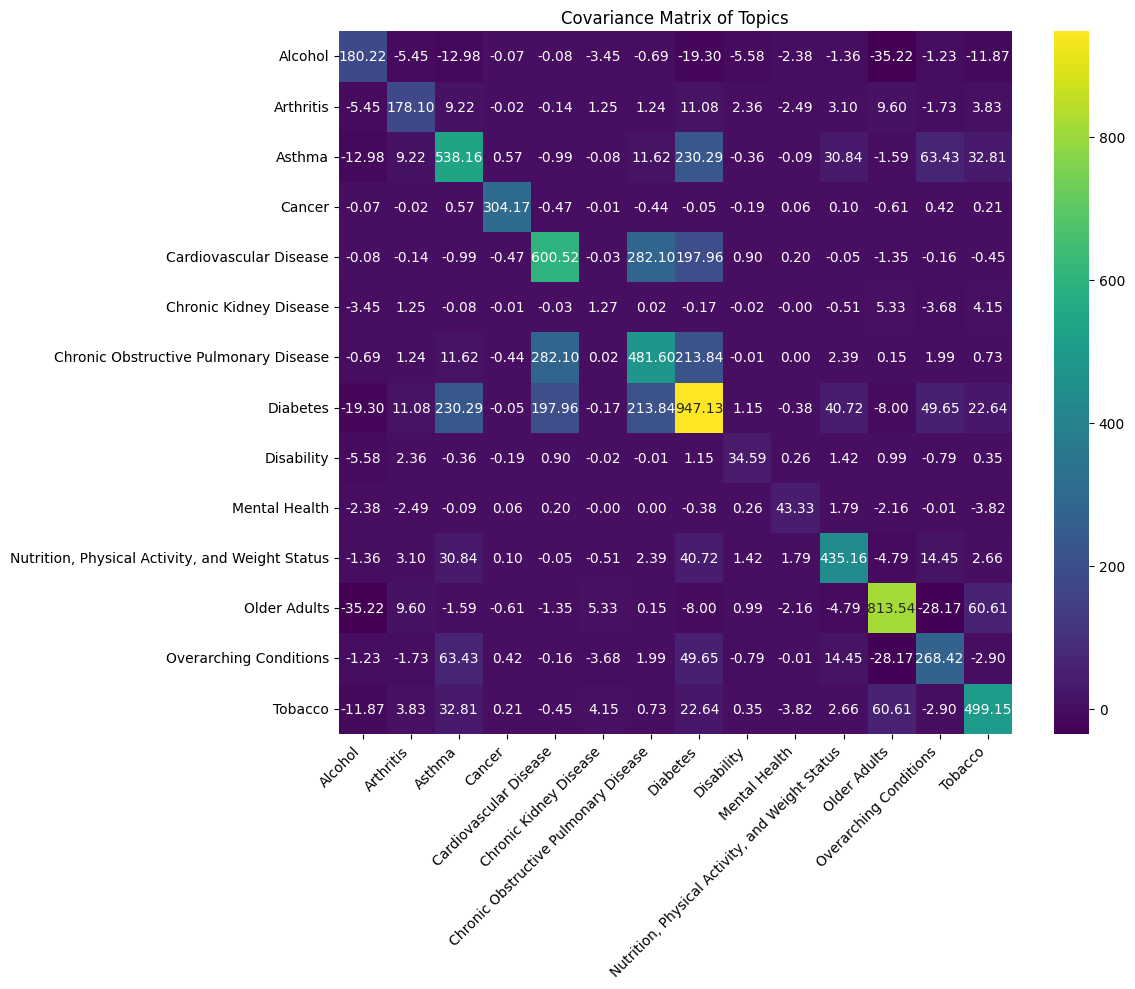

In [ ]:

topic_data = data.groupby('Topic')['StandardizedDataValue'].apply(list).to_dict()
max_len = max(len(lst) for lst in topic_data.values())

for topic, lst in topic_data.items():
    topic_data[topic] = lst + [np.nan] * (max_len - len(lst))

topic_df = pd.DataFrame(topic_data)

covariance_matrix = topic_df.cov()

plt.figure(figsize=(12, 10))  # Adjust figure size for better visibility
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='viridis',
            xticklabels=covariance_matrix.columns, yticklabels=covariance_matrix.columns)
plt.title('Covariance Matrix of Topics')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:

topic_data = data.groupby('Question')['StandardizedDataValue'].apply(list).to_dict()
topic_mapping = data.set_index('Question')['Topic'].to_dict()

max_len = max(len(lst) for lst in topic_data.values())

for topic, lst in topic_data.items():
    topic_data[topic] = lst + [np.nan] * (max_len - len(lst))

topic_df = pd.DataFrame(topic_data)

# Compute covariance matrix
covariance_matrix = topic_df.cov()

# Extract the specific row for "Arthritis among adults aged >= 18 years"
target_question = "Arthritis among adults aged >= 18 years"

arthritis_covariances = covariance_matrix.loc[target_question]

arthritis_topic = topic_mapping.get(target_question, "")

arthritis_covariances = arthritis_covariances.drop(target_question)

filtered_covariances = arthritis_covariances[[q for q in arthritis_covariances.index if topic_mapping.get(q, "") != arthritis_topic]]

top_20_related = filtered_covariances.nlargest(30)

print("Top 20 Questions (from different topics) Most Related to Arthritis:")
print(top_20_related.to_string())



Top 20 Questions (from different topics) Most Related to Arthritis:
Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease                                               7.573693
Secondary schools that offer less healthy foods as competitive foods                                                                                7.235016
Current smoking among adults aged >= 18 years                                                                                                       7.128479
Obesity among adults aged >= 18 years                                                                                                               6.007733
Percent tobacco revenue to fund at CDC recommended level                                                                                            5.929308
Visits to dentist or dental clinic among adults aged >= 18 years with diagnosed diabetes                                                           

In [ ]:

df_arthritis = data[data["Topic"] == "Arthritis"].copy()

# Create a list of Arthritis questions
arthritis_questions = df_arthritis["Question"].unique().tolist()

print("Arthritis Questions:")
for q in arthritis_questions:
    print("-", q)

# Optionally, create a list of Arthritis QuestionIDs
arthritis_question_ids = df_arthritis["QuestionID"].unique().tolist()

print("\nArthritis QuestionIDs:")
for qid in arthritis_question_ids:
    print("-", qid)


Arthritis Questions:
- Adults aged >= 18 years with arthritis who have taken a class to learn how to manage arthritis symptoms
- Arthritis among adults aged >= 18 years who are obese
- Arthritis among adults aged >= 18 years who have diabetes
- Arthritis among adults aged >= 18 years
- Physical inactivity among adults aged >= 18 years with arthritis
- Fair or poor health among adults aged >= 18 years with arthritis
- Arthritis among adults aged >= 18 years who have heart disease
- Work limitation due to arthritis among adults aged 18-64 years who have doctor-diagnosed arthritis
- Activity limitation due to arthritis among adults aged >= 18 years who have doctor-diagnosed arthritis
- Severe joint pain due to arthritis among adults aged >= 18 years who have doctor-diagnosed arthritis

Arthritis QuestionIDs:
- ART5_0
- ART1_2
- ART1_3
- ART1_1
- ART3_0
- ART4_0
- ART1_4
- ART2_3
- ART2_1
- ART2_2


In [ ]:

feature_questions  =["Obesity among adults aged >= 18 years",
 "Overweight or obesity among adults aged >= 18 years",
 "Meeting aerobic physical activity guidelines for additional and more extensive health benefits among adults aged >= 18 years",
 "Meeting aerobic physical activity guidelines for substantial health benefits among adults aged >= 18 years ",
 "Prevalence of chronic obstructive pulmonary disease among adults >= 18",
"No leisure-time physical activity among adults aged >= 18 years",
"Prevalence of diagnosed diabetes among adults aged >= 18 years " ,
"Participation in daily school physical education classes among high school students "
 "Prevalence of current smoking among adults >= 18 with diagnosed chronic obstructive pulmonary disease"
"Secondary schools that offer less healthy foods as competitive foods"
"Current smoking among adults aged >= 18 years",
    "Heavy drinking among adults aged >= 18 years",
                     "Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with a history of coronary heart disease",
    "High cholesterol prevalence among adults aged >= 18 years",
    "Awareness of high blood pressure among adults aged >= 18 years",
    "Recent physically unhealthy days among adults aged >= 18 years",
    "Arthritis among adults aged >= 18 years"
]

df_filtered = data[data["Question"].isin(feature_questions)].copy()

lookup_pairs = df_filtered[["Question", "QuestionID"]].drop_duplicates()

question_text_to_id = dict(zip(lookup_pairs["Question"], lookup_pairs["QuestionID"]))


In [ ]:
print(question_text_to_id)

{'Arthritis among adults aged >= 18 years': 'ART1_1', 'Recent physically unhealthy days among adults aged >= 18 years': 'OVC7_1', 'Heavy drinking among adults aged >= 18 years': 'ALC5_1', 'High cholesterol prevalence among adults aged >= 18 years': 'CVD5_0', 'Obesity among adults aged >= 18 years': 'NPAW1_1', 'Overweight or obesity among adults aged >= 18 years': 'NPAW2_1', 'Awareness of high blood pressure among adults aged >= 18 years': 'CVD6_1', 'Prevalence of chronic obstructive pulmonary disease among adults >= 18': 'COPD2_0', 'No leisure-time physical activity among adults aged >= 18 years': 'NPAW10_0', 'Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with a history of coronary heart disease': 'CVD10_1', 'Meeting aerobic physical activity guidelines for additional and more extensive health benefits among adults aged >= 18 years': 'NPAW11_3'}


In [ ]:

target_question = "Arthritis among adults aged >= 18 years"

df_filtered["QuestionID"] = df_filtered["Question"].map(question_text_to_id)

pivot_df = (
    df_filtered
    .pivot_table(
        index=["YearStart", "YearEnd", "State"],
        columns="QuestionID",
        values="StandardizedDataValue",
        aggfunc="mean"
    )
    .reset_index()
)

if "ART1_1" in pivot_df.columns:
    pivot_df.rename(columns={"ART1_1": "Arthritis_Target"}, inplace=True)



In [ ]:
print(pivot_df)

QuestionID  YearStart  YearEnd          State    ALC5_1  Arthritis_Target  \
0                2011     2011        Alabama  4.800000         29.000000   
1                2011     2011         Alaska  6.600000         20.142857   
2                2011     2011        Arizona  6.000000         22.125000   
3                2011     2011       Arkansas  6.000000         26.750000   
4                2011     2011     California  5.500000         21.375000   
..                ...      ...            ...       ...               ...   
565              2021     2021       Virginia  6.428571         23.250000   
566              2021     2021     Washington  5.857143         21.500000   
567              2021     2021  West Virginia  4.500000         32.500000   
568              2021     2021      Wisconsin  7.500000         23.142857   
569              2021     2021        Wyoming  6.000000         21.714286   

QuestionID    COPD2_0    CVD10_1     CVD5_0     CVD6_1   NPAW10_0  NPAW11_3

In [ ]:

pivot_df = pivot_df.drop(columns=['YearStart', 'QuestionID'], errors='ignore')
label_encoder = LabelEncoder()
pivot_df['State'] = label_encoder.fit_transform(pivot_df['State'])


In [ ]:
states_label=label_encoder.classes_

In [ ]:
states_label

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [ ]:
# Handling missing values by filling with median
imputer = SimpleImputer(strategy='median')
pivot_df_filled = pd.DataFrame(imputer.fit_transform(pivot_df.iloc[:, 1:]))
pivot_df_filled.columns = pivot_df.columns[1:]

In [ ]:
pivot_df_filled

QuestionID,State,ALC5_1,Arthritis_Target,COPD2_0,CVD10_1,CVD5_0,CVD6_1,NPAW10_0,NPAW11_3,NPAW1_1,NPAW2_1,OVC7_1
0,0.0,4.800000,29.000000,9.333333,53.200000,42.375000,39.250000,34.142857,30.0,30.571429,63.625000,4.333333
1,1.0,6.600000,20.142857,6.000000,51.000000,31.000000,27.857143,23.857143,30.0,27.000000,65.857143,3.333333
2,2.0,6.000000,22.125000,4.400000,43.250000,36.625000,26.500000,25.000000,30.0,26.000000,62.625000,3.333333
3,3.0,6.000000,26.750000,7.200000,45.500000,36.750000,32.500000,30.142857,30.0,27.375000,63.125000,4.333333
4,4.0,5.500000,21.375000,4.750000,41.400000,35.125000,28.875000,18.250000,30.0,23.875000,59.375000,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
565,47.0,6.428571,23.250000,5.714286,48.250000,35.375000,31.125000,19.750000,30.0,31.500000,65.625000,2.875000
566,48.0,5.857143,21.500000,4.250000,56.666667,31.375000,28.500000,19.125000,30.0,29.875000,64.500000,3.000000
567,49.0,4.500000,32.500000,12.857143,52.750000,37.375000,40.250000,27.750000,30.0,38.625000,70.750000,4.625000
568,50.0,7.500000,23.142857,5.000000,42.000000,29.875000,28.714286,21.714286,30.0,35.000000,68.375000,2.875000


In [ ]:
pivot_df_filled.insert(0, 'YearEnd', pivot_df['YearEnd'])

In [ ]:
pivot_df_filled

QuestionID,YearEnd,State,ALC5_1,Arthritis_Target,COPD2_0,CVD10_1,CVD5_0,CVD6_1,NPAW10_0,NPAW11_3,NPAW1_1,NPAW2_1,OVC7_1
0,2011,0.0,4.800000,29.000000,9.333333,53.200000,42.375000,39.250000,34.142857,30.0,30.571429,63.625000,4.333333
1,2011,1.0,6.600000,20.142857,6.000000,51.000000,31.000000,27.857143,23.857143,30.0,27.000000,65.857143,3.333333
2,2011,2.0,6.000000,22.125000,4.400000,43.250000,36.625000,26.500000,25.000000,30.0,26.000000,62.625000,3.333333
3,2011,3.0,6.000000,26.750000,7.200000,45.500000,36.750000,32.500000,30.142857,30.0,27.375000,63.125000,4.333333
4,2011,4.0,5.500000,21.375000,4.750000,41.400000,35.125000,28.875000,18.250000,30.0,23.875000,59.375000,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,2021,47.0,6.428571,23.250000,5.714286,48.250000,35.375000,31.125000,19.750000,30.0,31.500000,65.625000,2.875000
566,2021,48.0,5.857143,21.500000,4.250000,56.666667,31.375000,28.500000,19.125000,30.0,29.875000,64.500000,3.000000
567,2021,49.0,4.500000,32.500000,12.857143,52.750000,37.375000,40.250000,27.750000,30.0,38.625000,70.750000,4.625000
568,2021,50.0,7.500000,23.142857,5.000000,42.000000,29.875000,28.714286,21.714286,30.0,35.000000,68.375000,2.875000


In [ ]:
pivot_df_filled = pivot_df_filled.sort_values(by=['State', 'YearEnd'])



In [ ]:
pivot_df_filled

QuestionID,YearEnd,State,ALC5_1,Arthritis_Target,COPD2_0,CVD10_1,CVD5_0,CVD6_1,NPAW10_0,NPAW11_3,NPAW1_1,NPAW2_1,OVC7_1
0,2011,0.0,4.80,29.000000,9.333333,53.200000,42.375000,39.250000,34.142857,30.000000,30.571429,63.625000,4.333333
52,2012,0.0,4.60,30.500000,9.666667,47.400000,33.500000,29.803571,25.125000,30.000000,29.500000,66.375000,4.500000
104,2013,0.0,4.00,33.857143,10.000000,49.400000,42.833333,42.714286,32.625000,25.500000,31.857143,68.285714,4.714286
156,2014,0.0,4.00,33.571429,10.666667,40.400000,33.500000,29.803571,25.125000,30.000000,31.625000,65.625000,3.875000
208,2015,0.0,4.20,28.000000,10.333333,51.600000,38.875000,39.285714,30.375000,26.625000,34.375000,67.000000,4.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2017,51.0,7.00,23.428571,5.800000,60.000000,26.000000,29.571429,26.285714,32.142857,29.428571,64.000000,3.571429
415,2018,51.0,7.00,24.166667,6.000000,29.500000,33.500000,29.803571,24.285714,30.000000,30.333333,65.000000,3.000000
466,2019,51.0,5.75,23.428571,6.500000,47.666667,27.333333,28.166667,25.500000,36.428571,29.571429,62.857143,4.000000
518,2020,51.0,6.40,21.142857,6.000000,49.000000,33.500000,29.803571,23.000000,30.000000,30.000000,66.428571,2.400000


In [ ]:
scaler = MinMaxScaler()
pivot_df_scaled = pd.DataFrame(scaler.fit_transform(pivot_df_filled.iloc[:, 1:]), columns=pivot_df_filled.columns[1:])



In [ ]:

sequence_length = 5
sequence_data = []
sequence_labels = []
states = pivot_df_scaled['State'].unique()

In [ ]:
states

array([0.        , 0.01960784, 0.03921569, 0.05882353, 0.07843137,
       0.09803922, 0.11764706, 0.1372549 , 0.15686275, 0.17647059,
       0.19607843, 0.21568627, 0.23529412, 0.25490196, 0.2745098 ,
       0.29411765, 0.31372549, 0.33333333, 0.35294118, 0.37254902,
       0.39215686, 0.41176471, 0.43137255, 0.45098039, 0.47058824,
       0.49019608, 0.50980392, 0.52941176, 0.54901961, 0.56862745,
       0.58823529, 0.60784314, 0.62745098, 0.64705882, 0.66666667,
       0.68627451, 0.70588235, 0.7254902 , 0.74509804, 0.76470588,
       0.78431373, 0.80392157, 0.82352941, 0.84313725, 0.8627451 ,
       0.88235294, 0.90196078, 0.92156863, 0.94117647, 0.96078431,
       0.98039216, 1.        ])

In [ ]:
for state in states:
    state_data = pivot_df_scaled[pivot_df_scaled['State'] == state]
    if 'Arthritis_Target' in pivot_df_scaled.columns:
        state_target = state_data['Arthritis_Target'].dropna()
        state_features = state_data.drop(columns=['Arthritis_Target',"Yeadend"], errors='ignore')

        # Create rolling windows of sequence_length
        for i in range(len(state_features) - sequence_length):
            sequence_data.append(state_features.iloc[i:i+sequence_length].values)
            sequence_labels.append(state_target.iloc[i+sequence_length])

# Convert to numpy arrays
sequence_data = np.array(sequence_data)
sequence_labels = np.array(sequence_labels)

sequence_data = np.reshape(sequence_data, (sequence_data.shape[0], sequence_length, sequence_data.shape[2]))



In [ ]:
sequence_data.shape

(310, 5, 11)

#Model Creation and Training


In [ ]:

# Define LSTM model
model = Sequential([
    Input(shape=(sequence_length, sequence_data.shape[2])),
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

model.fit(sequence_data, sequence_labels, epochs=50, batch_size=16, verbose=1)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.1310
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0075
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061
Epoch 16/50
20/20 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

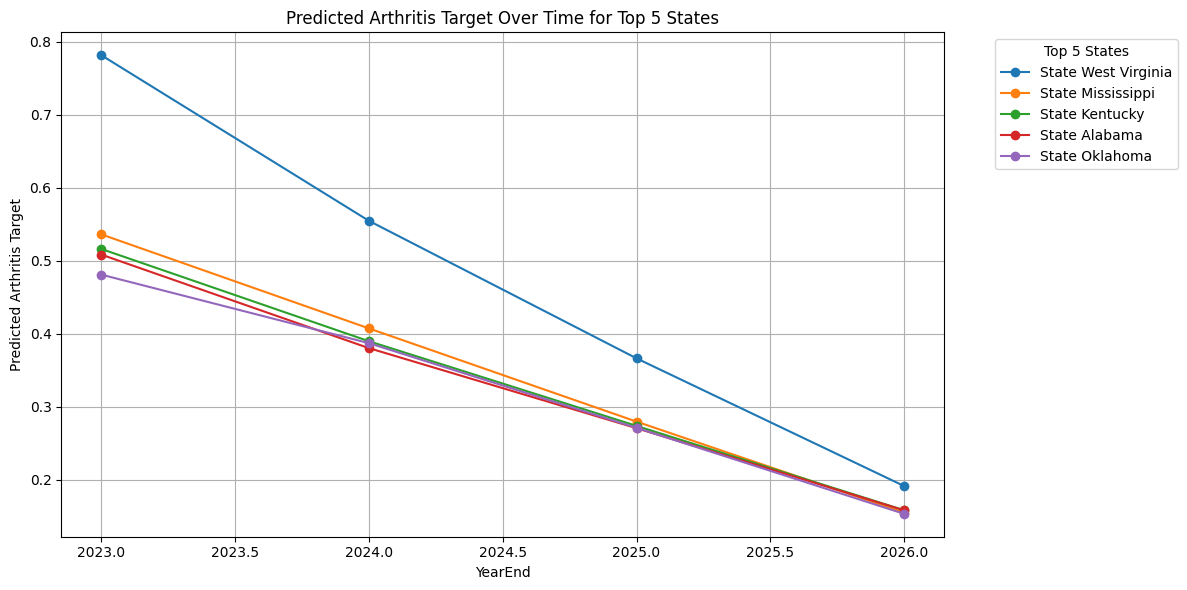

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

future_years = [2023, 2024, 2025, 2026]
future_predictions = []

for state in states:
    recent_data = pivot_df_scaled[pivot_df_scaled['State'] == state].iloc[-sequence_length:].drop(columns=['Arthritis_Target'], errors='ignore')
    recent_data = np.reshape(recent_data.values, (1, sequence_length, recent_data.shape[1]))

    for year in future_years:
        prediction = model.predict(recent_data)[0][0]
        future_predictions.append((year, state, prediction))

        # Create a new row with the correct number of features
        new_row = np.zeros((1, 1, recent_data.shape[2]))  # Initialize with zeros
        new_row[0, 0, 0] = prediction  # Assign the prediction to the first feature

        # Concatenate the new row to recent_data
        recent_data = np.concatenate([recent_data, new_row], axis=1)
        recent_data = recent_data[:, -sequence_length:, :]  # Keep sequence length consistent

prediction_df = pd.DataFrame(future_predictions, columns=['YearEnd', 'State', 'Arthritis_Target_Predicted'])

top_5_states = (
    prediction_df.groupby("State")["Arthritis_Target_Predicted"]
    .mean()
    .nlargest(5)
    .index
)

top_5_prediction_df = prediction_df[prediction_df["State"].isin(top_5_states)]

plt.figure(figsize=(12, 6))
for state in top_5_states:
    state_data = top_5_prediction_df[top_5_prediction_df['State'] == state]
    plt.plot(state_data['YearEnd'], state_data['Arthritis_Target_Predicted'], marker='o', label=f'State {states_label[int(state*51)]}')

plt.xlabel('YearEnd')
plt.ylabel('Predicted Arthritis Target')
plt.title('Predicted Arthritis Target Over Time for Top 5 States')
plt.legend(title="Top 5 States", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()
